### Import related library

In [64]:
import numpy as np
import os
import sys
import tarfile
import zipfile
import six.moves.urllib as urllib

import tensorflow as tf

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import PIL.Image

import pandas as pd

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path
sys.path.append(r'D:\Work\tensorflow\models\research\object_detection')

from object_detection.builders import dataset_builder
from utils import label_map_util
from utils import visualization_utils as vis_util


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

In [6]:
import matplotlib as mp
import PIL as pil

In [8]:
## Check the version  of the important library
print('Tensorflow : {}'.format(tf.__version__))
print('matplotlib : {}'.format(mp.__version__))
print('PIL-Image  : {}'.format(pil.__version__))

Tensorflow : 1.12.0
matplotlib : 2.1.0
PIL-Image  : 4.0.0


# Reading image exif(Exchangeable image file format) information

### Function Block

All the below funciton will use for  

**get_exif_data** : Extract GPSInfo tag for all of the image properties. 

**_get_if_exist** : Return the value for sub tag under GPSInfo if that tag exists  

**_convert_to_degress** : It'll convert the GPSInfo tag into degree format which is more readable for user.

**get_lat_lon** : search the GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef to prepare the GPS info

In [17]:
## Function to read the GPS information and convert into lat lon

def get_exif_data(image):
    """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
    exif_data = {}
    info = image._getexif()
    if info:
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            if decoded == "GPSInfo":
                gps_data = {}
                for t in value:
                    sub_decoded = GPSTAGS.get(t, t)
                    gps_data[sub_decoded] = value[t]

                exif_data[decoded] = gps_data
            else:
                exif_data[decoded] = value

    return exif_data

def _get_if_exist(data, key):
    if key in data:
        return data[key]

    return None

def _convert_to_degress(value):
    """Helper function to convert the GPS coordinates stored in the EXIF to degress in float format"""
    d0 = value[0][0]
    d1 = value[0][1]
    d = float(d0) / float(d1)

    m0 = value[1][0]
    m1 = value[1][1]
    m = float(m0) / float(m1)

    s0 = value[2][0]
    s1 = value[2][1]
    s = float(s0) / float(s1)

    return d + (m / 60.0) + (s / 3600.0)

def get_lat_lon(exif_data):
    """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
    lat = None
    lon = None

    if "GPSInfo" in exif_data:
        gps_info = exif_data["GPSInfo"]

        gps_latitude      = _get_if_exist(gps_info, "GPSLatitude")
        gps_latitude_ref  = _get_if_exist(gps_info, 'GPSLatitudeRef')
        gps_longitude     = _get_if_exist(gps_info, 'GPSLongitude')
        gps_longitude_ref = _get_if_exist(gps_info, 'GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            lat = _convert_to_degress(gps_latitude)
            if gps_latitude_ref != "N":                     
                lat = 0 - lat

            lon = _convert_to_degress(gps_longitude)
            if gps_longitude_ref != "E":
                lon = 0 - lon

    return lat, lon

In [52]:
## Input Image path
PATH_TO_TEST_IMAGES_DIR = os.getcwd()+r'\test_image'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 20) ]
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR,i) for i in os.listdir(PATH_TO_TEST_IMAGES_DIR)  if i.endswith('.jpg')]
print(len(TEST_IMAGE_PATHS))
TEST_IMAGE_PATHS

20


['D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_111831.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_112156.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_112214.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_112231.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_113635.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_113708.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_113810.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114026.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114029.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114156.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114206.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114342.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114909.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20200607_114913.jpg',
 'D:\\MY\\UM\\Semester_6\\Python\\test_image\\20

In [53]:
file_name_list = []
file_count = 0
iter_count = 1
csv_file   = 'logo_file.csv'

for files in TEST_IMAGE_PATHS:
    
    file_name = os.path.basename(files)
    
    ## Trying to read the file having the lat long in the file name.
    ## Source of this file extracted manually from Google Map
    try:
        lat, lon = file_name.replace('.jpg','').split(' ')
        file_name_list.append([file_name,lat,lon])
    
    ##Read the location information from image properties (exif)
    except:
        image = PIL.Image.open(files)
        #image = ... # load an image through PIL's Image object
        exif_data = get_exif_data(image)
        #print (files,',',get_lat_lon(exif_data))
        lat, lon = get_lat_lon(exif_data)
        file_name_list.append((file_name, lat, lon))
   


In [24]:
get_lat_lon(exif_data).split(',')

101.67083333333333

In [55]:
len(file_name_list)

20

In [56]:
pd.DataFrame(file_name_list, columns = ['file_name','lat','lon'])

file_name        lat          lon
0         20200607_111831.jpg     3.1275       101.67
1         20200607_112156.jpg    3.12791       101.67
2         20200607_112214.jpg    3.12792       101.67
3         20200607_112231.jpg    3.12794       101.67
4         20200607_113635.jpg     3.1325      101.672
5         20200607_113708.jpg    3.13278      101.672
6         20200607_113810.jpg    3.13278      101.672
7         20200607_114026.jpg    3.13268      101.673
8         20200607_114029.jpg    3.13268      101.673
9         20200607_114156.jpg    3.13277      101.671
10        20200607_114206.jpg     3.1325       101.67
11        20200607_114342.jpg    3.13052       101.67
12        20200607_114909.jpg    3.12778      101.671
13        20200607_114913.jpg     3.1281      101.671
14        20200607_114922.jpg    3.12806      101.671
15   3.120138 101.6792171.jpg   3.120138  101.6792171
16  3.1262711 101.6773883.jpg  3.1262711  101.6773883
17   3.1278196 101.670482.jpg  3.1278196   101.670482
18  3.1322259 101.6731573.jpg  3.1322259  101.6731573
19    3.132320 101.673147.jpg   3.132320   101.673147

In [57]:
##Create dataframe with image information
df_test_file = pd.DataFrame(file_name_list, columns = ['file_name','lat','lon'])

# Detecting Logo from the image

### Load the trained model

In [58]:
# What model to download.
MODEL_NAME = os.getcwd()+r'\trained-inference-graphs\faster_rcnn_inception_v3_coco_UM_GPU'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + r'\frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'label_map.pbtxt')

# Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `1`, we know that this corresponds to `SCB`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [32]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'SCB'},
 2: {'id': 2, 'name': 'CIMB'},
 3: {'id': 3, 'name': 'MBB'},
 4: {'id': 4, 'name': 'HSBC'},
 5: {'id': 5, 'name': 'UMOBILE'},
 6: {'id': 6, 'name': 'DIGI'},
 7: {'id': 7, 'name': 'CELCOM'},
 8: {'id': 8, 'name': 'MAXIS'}}

In [59]:
# Size, in inches, of the output images.
IMAGE_SIZE = (13, 8)

## Convert image into numpy array
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detect the target logo from input image
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

### Detect the logo from test images and tagged the class detected within the image

D:\MY\UM\Semester_6\Python/test_image/20200607_111831.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_112156.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_112214.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_112231.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_113635.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_113708.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_113810.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114026.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114029.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114156.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114206.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114342.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114909.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114913.jpg
D:\MY\UM\Semester_6\Python/test_image/20200607_114922.jpg
D:\MY\UM\Semester_6\Python/test_image/3.120138 101.6792171.jpg
D:\MY\UM\Semester_6\Python/test_image/3.1262711 101.6773883.jpg
D:\

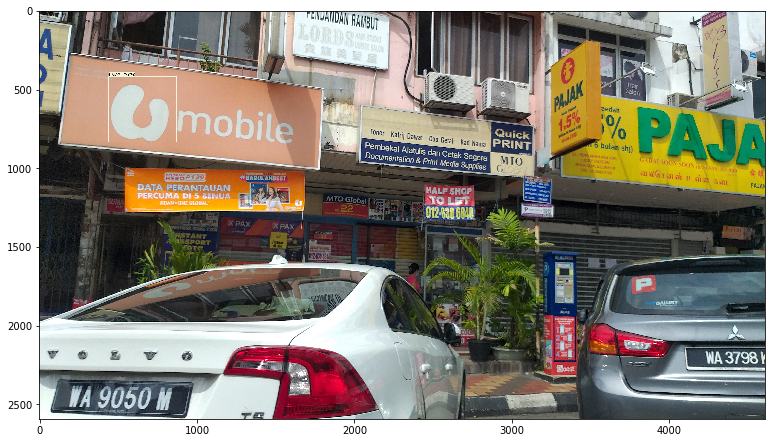

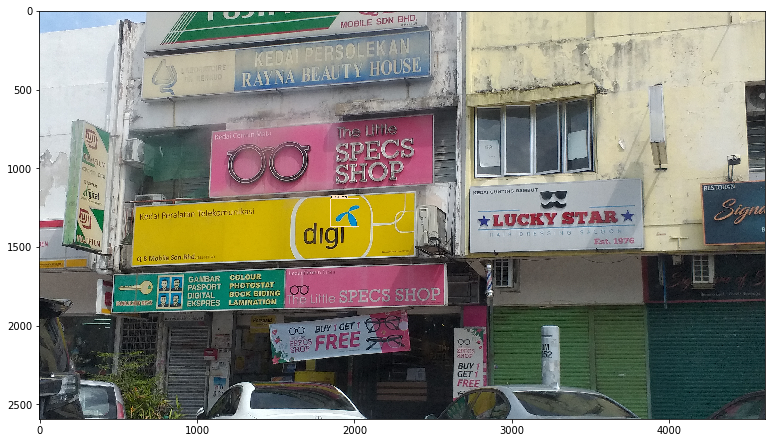

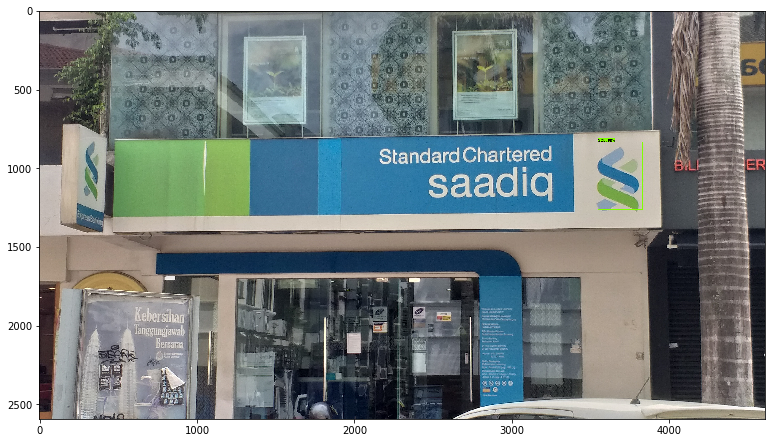

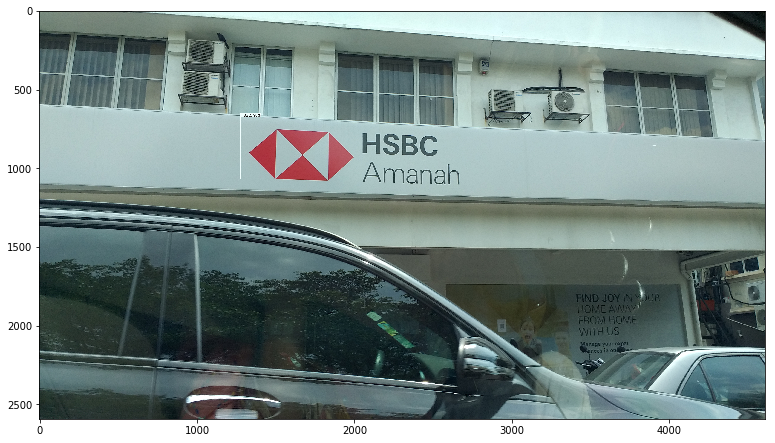

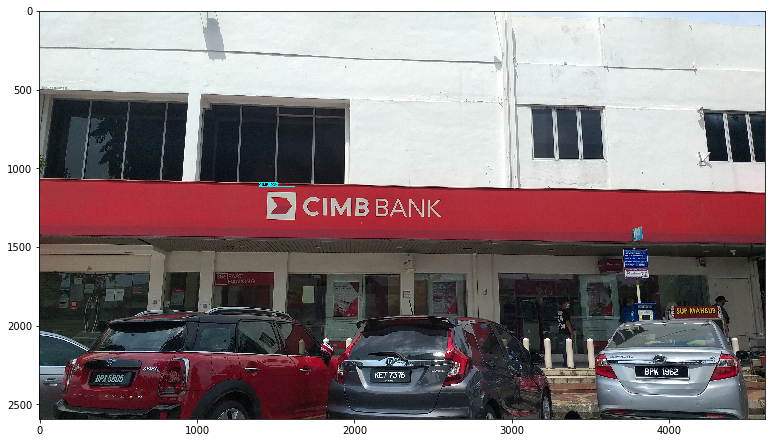

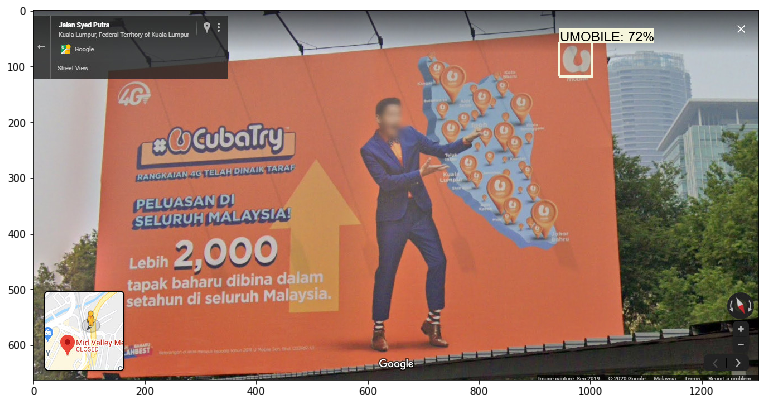

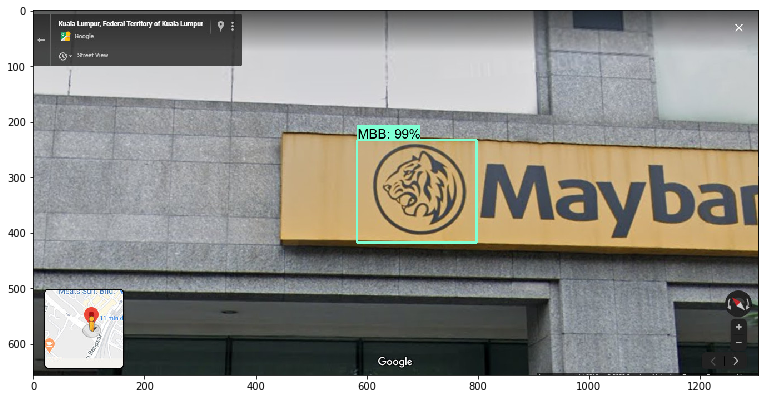

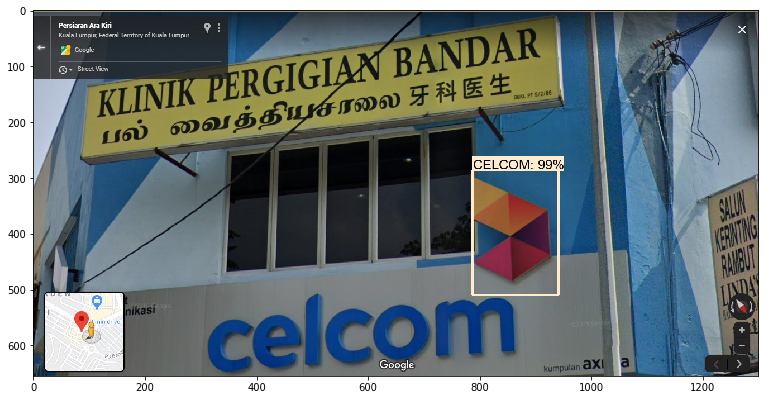

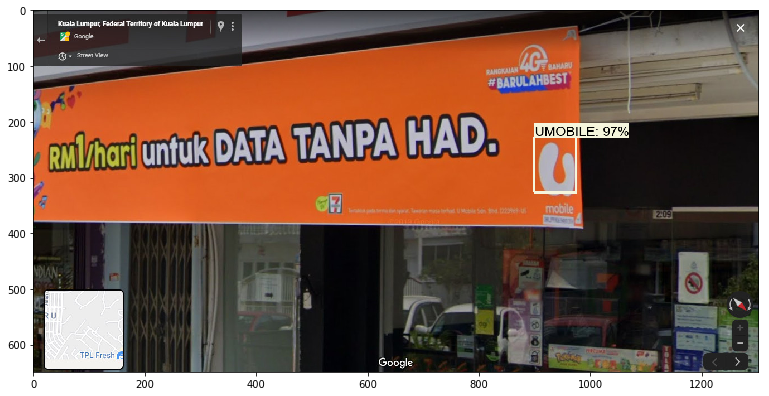

In [61]:
lst_img=[]

_min_score_thresh = .5
lst_img=[]

#for image_path in TEST_IMAGE_PATHS:
for index, row in df_test_file.iterrows():
    
    image_path=os.getcwd()+r'/test_image/'+row['file_name']
    
    print(image_path)   
    
    file_name = os.path.basename(image_path)
    #lat, lon = file_name.replace('.jpg','').split(' ')    
    
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    #print(output_dict['detection_classes'])
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          min_score_thresh=_min_score_thresh,
          line_thickness=4)    
    
    if len(list(filter(lambda X: X>=_min_score_thresh,output_dict['detection_scores']))) > 0 :
        
        OD         = list(filter(lambda X: X>=_min_score_thresh,output_dict['detection_scores']))[0]
        idx        = list(output_dict['detection_scores']).index(OD)
        class_idx  = output_dict['detection_classes'][idx]
        class_name = category_index[class_idx]['name']


        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        plt.savefig(os.getcwd()+r'\detected\Detected_'+class_name+'_'+file_name)
        
        lst_img.append([row['file_name'],row['lat'],row['lon'],class_name,'Detected_'+file_name,'https://maps.google.com/?q='+str(row['lat'])+','+str(row['lon'])])
    else:
        lst_img.append([row['file_name'],row['lat'],row['lon'],'','','https://maps.google.com/?q='+str(row['lat'])+','+str(row['lon'])] )
    
    
    OD=idx=class_idx=class_name = ''

In [65]:
pd.DataFrame(lst_img,columns = ['file_name','lat','lon','Class','saved_image','Google_URL'])

file_name        lat          lon    Class  \
0         20200607_111831.jpg     3.1275       101.67            
1         20200607_112156.jpg    3.12791       101.67            
2         20200607_112214.jpg    3.12792       101.67  UMOBILE   
3         20200607_112231.jpg    3.12794       101.67     DIGI   
4         20200607_113635.jpg     3.1325      101.672            
5         20200607_113708.jpg    3.13278      101.672      SCB   
6         20200607_113810.jpg    3.13278      101.672            
7         20200607_114026.jpg    3.13268      101.673            
8         20200607_114029.jpg    3.13268      101.673            
9         20200607_114156.jpg    3.13277      101.671            
10        20200607_114206.jpg     3.1325       101.67            
11        20200607_114342.jpg    3.13052       101.67     HSBC   
12        20200607_114909.jpg    3.12778      101.671            
13        20200607_114913.jpg     3.1281      101.671     CIMB   
14        20200607_114922.jpg    3.12806      101.671            
15   3.120138 101.6792171.jpg   3.120138  101.6792171  UMOBILE   
16  3.1262711 101.6773883.jpg  3.1262711  101.6773883      MBB   
17   3.1278196 101.670482.jpg  3.1278196   101.670482   CELCOM   
18  3.1322259 101.6731573.jpg  3.1322259  101.6731573  UMOBILE   
19    3.132320 101.673147.jpg   3.132320   101.673147            

                           saved_image  \
0                                        
1                                        
2         Detected_20200607_112214.jpg   
3         Detected_20200607_112231.jpg   
4                                        
5         Detected_20200607_113708.jpg   
6                                        
7                                        
8                                        
9                                        
10                                       
11        Detected_20200607_114342.jpg   
12                                       
13        Detected_20200607_114913.jpg   
14                                       
15   Detected_3.120138 101.6792171.jpg   
16  Detected_3.1262711 101.6773883.jpg   
17   Detected_3.1278196 101.670482.jpg   
18  Detected_3.1322259 101.6731573.jpg   
19                                       

                                                          Google_URL  
0               https://maps.google.com/?q=3.1275,101.67027777777778  
1   https://maps.google.com/?q=3.1279091944444444,101.67032158333333  
2   https://maps.google.com/?q=3.1279190833333335,101.67028977777778  
3   https://maps.google.com/?q=3.1279361944444446,101.67028247222223  
4               https://maps.google.com/?q=3.1325,101.67194444444445  
5   https://maps.google.com/?q=3.1327777777777777,101.67194444444445  
6   https://maps.google.com/?q=3.1327777777777777,101.67194444444445  
7           https://maps.google.com/?q=3.132684888888889,101.6725095  
8           https://maps.google.com/?q=3.132684888888889,101.6725095  
9    https://maps.google.com/?q=3.1327686944444446,101.6706753888889  
10              https://maps.google.com/?q=3.1325,101.67027777777778  
11  https://maps.google.com/?q=3.1305222777777777,101.67044408333334  
12  https://maps.google.com/?q=3.1277777777777778,101.67083333333333  
13  https://maps.google.com/?q=3.1280995833333334,101.67078277777779  
14  https://maps.google.com/?q=3.1280555555555556,101.67055555555557  
15                   https://maps.google.com/?q=3.120138,101.6792171  
16                  https://maps.google.com/?q=3.1262711,101.6773883  
17                   https://maps.google.com/?q=3.1278196,101.670482  
18                  https://maps.google.com/?q=3.1322259,101.6731573  
19                    https://maps.google.com/?q=3.132320,101.673147

In [66]:
pd.DataFrame(lst_img,columns = ['file_name','lat','lon','Class','saved_image','Google_URL']).to_csv('image_dataset.csv',index=False)